In [7]:
import os
import shutil
import warnings
from pathlib import Path

import matplotlib.pylab as plt
import numpy as np
import pandas as pd
import pyarrow as pa
import pyarrow.parquet as pq
from sklearn.metrics import (
    accuracy_score,
    auc,
    classification_report,
    f1_score,
    precision_recall_curve,
    precision_score,
    recall_score,
)
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm

warnings.filterwarnings("ignore")

train_path = "/tmp/train_data.parquet"
test_path = "/tmp/test_data.parquet"

# Create Parquet Data

In [2]:
from imblearn.under_sampling import RandomUnderSampler
from sklearn.datasets import make_classification
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

np.random.seed(0)
x_data, y_data = make_classification(
    n_samples=1000000,
    n_features=8,
    n_informative=4,
    n_clusters_per_class=3,
    class_sep=0.6,
    weights=(0.9, 0.1),
    hypercube=False,
)

x_data = pd.DataFrame(
    np.hstack([x_data, y_data.reshape(-1, 1)]),
    columns=["a", "b", "c", "d", "e", "f", "g", "h", "y"],
)
train_data, test_data = train_test_split(x_data, test_size=0.3, random_state=42)

print("train_data:", train_data.shape)
print("test_data :", test_data.shape)

train_data.to_parquet(train_path)
test_data.to_parquet(test_path)

train_data: (700000, 9)
test_data : (300000, 9)


# Tools

In [3]:
def calculate_prauc(y_true, y_prob, plot, label, method=[]):
    from collections.abc import Iterable

    def point_optimal_threshold(name):
        # Other Metrics at the max_threshold

        acc_ = accuracy_score(y_true, y_prob >= max_threshold)
        f1_ = f1_score(y_test, y_prob >= max_threshold)

        plot.plot(
            recall[max_idx],
            precision[max_idx],
            marker="o",
            markersize=10,
            label=f"{label} | {name:5} | optimal threshold: {max_threshold}",
        )

    if not isinstance(method, Iterable):
        method = [method]

    precision, recall, thresholds = precision_recall_curve(y_true, y_prob)
    auc_ = auc(recall, precision)
    plot.plot(recall, precision, label=f"{label} | prauc:{auc_:.4f})")

    # Optimize the thesholds
    best_threshold = None
    if "diff" in method:
        max_idx = np.argmax(recall - precision)
        max_threshold = thresholds[max_idx]
        point_optimal_threshold("diff")
        best_threshold = max_threshold

    if "plus" in method:
        max_idx = np.argmax(recall + precision)
        max_threshold = thresholds[max_idx]
        point_optimal_threshold("plus")
        best_threshold = max_threshold

    if "f1" in method:
        fscores = 2 * (precision * recall) / (precision + recall)
        max_idx = np.argmax(fscores)
        max_threshold = thresholds[max_idx]
        point_optimal_threshold("f1")
        best_threshold = max_threshold
    return best_threshold

# LGBMClassifier

[LightGBM] [Info] Number of positive: 72683, number of negative: 627317
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001490 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 700000, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.103833 -> initscore=-2.155344
[LightGBM] [Info] Start training from score -2.155344
scale_pos_weight: 0.8961671428571428
Accuracy : 0.92689
Precision: 0.8745577356063042
Recall   : 0.34804313738039616
F1 Score : 0.49792835069245733


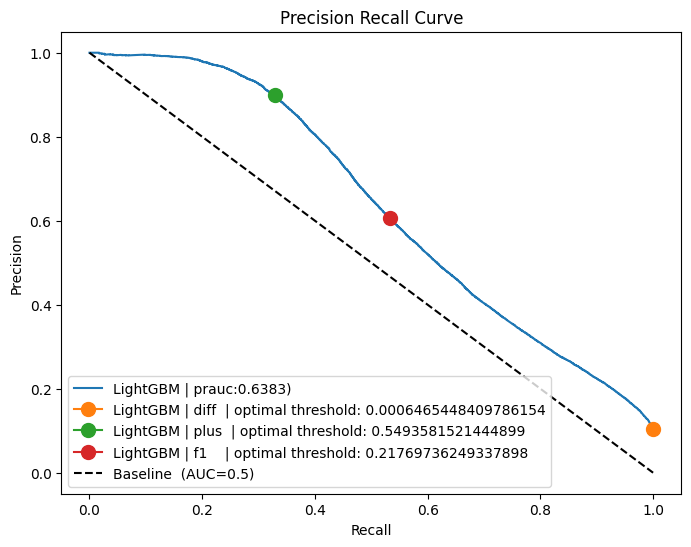

In [53]:
from lightgbm import LGBMClassifier

# Data
x_train = train_data.drop("y", axis=1)
y_train = train_data["y"]
x_test = test_data.drop("y", axis=1)
y_test = test_data["y"]
scale_pos_weight = sum(y_train == 0) / len(y_train)

# Train
model = LGBMClassifier(
    metrics="prauc",
    n_estimators=100,
    scale_pos_weight=scale_pos_weight,
    random_state=32,
)
model.fit(x_train, y_train)

# Predict
y_pred = model.predict_proba(x_test)[:, 1] >= 0.5
y_prob = model.predict_proba(x_test)[:, 1]


# Model Performance
print("scale_pos_weight:", scale_pos_weight)
print("Accuracy :", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall   :", recall_score(y_test, y_pred))
print("F1 Score :", f1_score(y_test, y_pred))


fig, plot = plt.subplots(1, figsize=(8, 6))
calculate_prauc(y_test, y_prob, plot, "LightGBM", ("diff", "plus", "f1"))

plot.plot([0, 1], [1, 0], "k--", label=f"Baseline  (AUC=0.5)")
plot.set_xlabel("Recall")
plot.set_ylabel("Precision")
plot.set_title(f"Precision Recall Curve")
plot.legend(loc="lower left")

# Continuous LearningData

In [5]:
def iter_data(data_path) -> pd.DataFrame:
    parquet_dataset = pq.ParquetDataset(data_path, use_legacy_dataset=False)
    for frag in parquet_dataset.fragments:
        for batch in frag.to_batches():
            yield batch.to_pandas()


def split_dataset(df):
    y_data = df["y"]
    df.drop("y", axis=1, inplace=True)
    return df, y_data

In [40]:
import lightgbm as lgb

params = {
    "boosting_type": "gbdt",
    "objective": "binary",
    "metric": "prauc",
    "num_leaves": 31,
    "num_iterations": 1,
    "max_bin": 2000,
    "num_threads": 12,
    "force_col_wise": True,
    "verbose": 0,
}

model = None
for epoch in tqdm(range(5), desc='epoch'):
    for data in iter_data(train_path):
        x_train, y_train = split_dataset(data)
        scale_pos_weight = sum(y_train == 0) / len(y_train)
    
        if model is None:
            model = lgb.train(params, 
                              lgb.Dataset(x_train, y_train), 
                              num_boost_round=10)
        else:
            model = lgb.train(params, 
                              lgb.Dataset(x_train, y_train), 
                              num_boost_round=10, 
                              init_model=model, 
                              keep_training_booster=True)

epoch:   0%|          | 0/5 [00:00<?, ?it/s]

scale_pos_weight: 0.896594982078853
Accuracy : 0.9231666666666667
Precision: 0.8784270285239546
Recall   : 0.30452174469583027
F1 Score : 0.45225987358015307


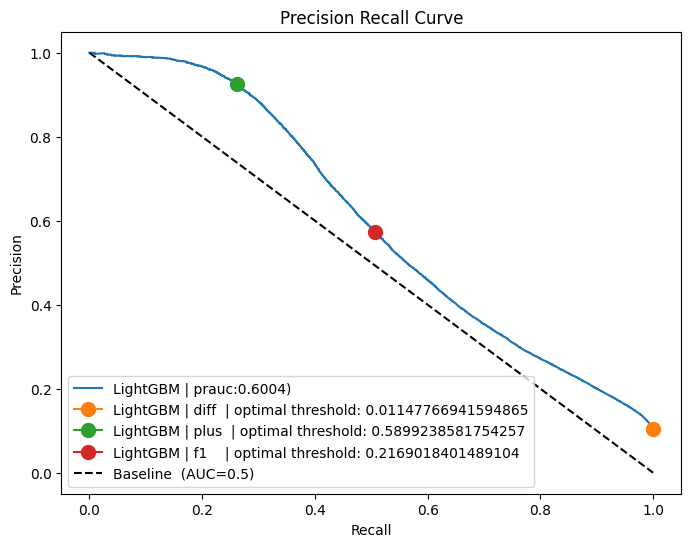

In [41]:
x_test = test_data.drop("y", axis=1)
y_test = test_data["y"]

# Predict
y_pred = model.predict(x_test) >= 0.5
y_prob = model.predict(x_test)


# Model Performance
print("scale_pos_weight:", scale_pos_weight)
print("Accuracy :", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall   :", recall_score(y_test, y_pred))
print("F1 Score :", f1_score(y_test, y_pred))


fig, plot = plt.subplots(1, figsize=(8, 6))
calculate_prauc(y_test, y_prob, plot, "LightGBM", ("diff", "plus", "f1"))

plot.plot([0, 1], [1, 0], "k--", label=f"Baseline  (AUC=0.5)")
plot.set_xlabel("Recall")
plot.set_ylabel("Precision")
plot.set_title(f"Precision Recall Curve")
plot.legend(loc="lower left")

## Feature importance

<Axes: title={'center': 'gain feature importance'}, xlabel='Feature importance', ylabel='Features'>

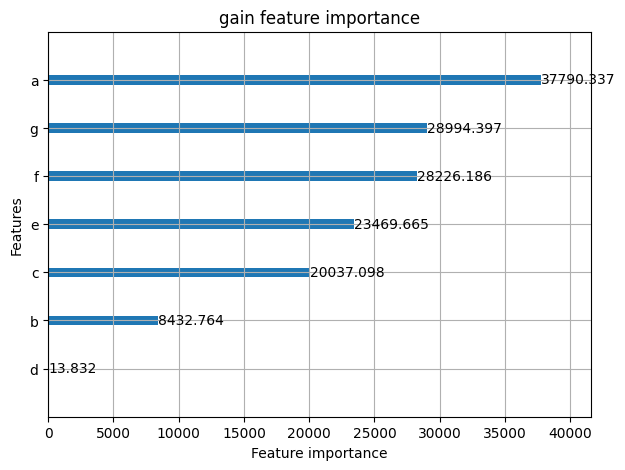

In [54]:
lgb.plot_importance(model, importance_type='gain', figsize=(7, 5), title='gain feature importance')

In [60]:
model.feature_importance(importance_type='gain')

array([3.77903369e+04, 8.43276426e+03, 2.00370975e+04, 1.38318949e+01,
       2.34696655e+04, 2.82261864e+04, 2.89943968e+04, 0.00000000e+00])

In [61]:
model.feature_name()

['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h']